### Aihemallinnusta: suomenkielisen demoskene-Wikipedia-sivun mallintaminen aiheisiin

Vaihtoehtototeutus: Tämä versio käyttää Tmtoolkit-kirjaston sisäistä Corpus-luokkaa ja sitä käyttäen saadaan dokumentti-termi-matriisi (koodissa dtm_) korpuksesta.

Tmtoolkit-kirjasto tarvitsee toimiakseen lda-kirjaston kanssa Python-version 3.8-3.10.

Aiheiden määrän määrittämiseen on käytetty tmtoolkit-kirjaston coherence_mimno_2011-metriikkaa.
Toteutusta varten kirjasto asennetaan seuraavasti:

pip install -U "tmtoolkit[recommended,lda]"

Huomaa, että yo. ei asenna lda-kirjastoa, joka on asennettava erikseen:

pip install -U lda

Tarvitaan myös spaCy:

pip install -U spacy

Tmtoolkit näyttää käyttävän itse pienintä spaCyn kielimallia:

python -m spacy download fi_core_news_sm

Lisää tietoa tmtoolkit-kirjaston verkkosivuilta:
https://tmtoolkit.readthedocs.io/en/latest/install.html

In [1]:
import wikipediaapi # pip install -U wikipedia-api

### Wikipedia-sivu noudettu 1.2.2024
- huomaa, että sivu on voinut muuttua ajankohdan jälkeen

In [2]:
wiki_html = wikipediaapi.Wikipedia(
    user_agent='Aihemallinnusjuttu',
    language='fi',
    extract_format=wikipediaapi.ExtractFormat.HTML
)

In [3]:
page_py = wiki_html.page("Demoskene")
p_html = page_py.text

pip3 install BeautifulSoup4

In [4]:
from bs4 import BeautifulSoup

In [5]:
html = BeautifulSoup(p_html, 'html.parser')

paragraphs = html.select("p, h2")

h2_found = False

kappaleet = {}

index = 0

for para in paragraphs:
    
    # Jotta Wikipedia-sivun yhteenveto ei tule mukaan, tarkastellaan,
    # milloin kohdataan ensimmäinen h2-tagi, sen jälkeen poimitaan
    # p-tagien eli kappaleiden sisältö
    if "<h2>" in str(para): h2_found = True

    if h2_found:
        
        if "<p>" in str(para):

            content = str(para.text)

            # autetaan SentenceSplitteriä jakamaan kappaleet virkkeisiin paremmin
            # mainittu osaa jakaa paremmin virkkeisiin kuin spaCy
            if "tuotokset.Tyyliltään" in content:
                content = content.replace("tuotokset.Tyyliltään", "tuotokset. Tyyliltään")
            # Poistetaan Wikipedia-sivun "lähde?"-ilmaisut
            if "lähde?" in content:
                content = content.replace("lähde?","")


            # Viimeisessä kappaleessa tiedetään (1.2.2024) olevan ei-tulostettava unicode-koodi,
            # eikä asiasisältöä
            if "\xa0" not in content:
                kappaleet[index] = content.replace("\n", " ")
                index += 1

pip install sentence-splitter

In [6]:
from sentence_splitter import SentenceSplitter

In [7]:
# vaikuttaa osavan suomen kielen...
splitter = SentenceSplitter(language="fi")

### Luodaan korpus

In [8]:
korpus = []

for kpl in kappaleet.values():
    korpus.append(kpl.strip())
print(len(korpus))

42


In [9]:
import matplotlib.pylab as plt
import numpy as np

Toteutuksessa on dokumenttiyksikkönä yksi kappale HTML-koodista poimittuna. Kuviossa on virkemäärien jakaumat aihemllinnuksen dokumenttiyksikköä kohden.

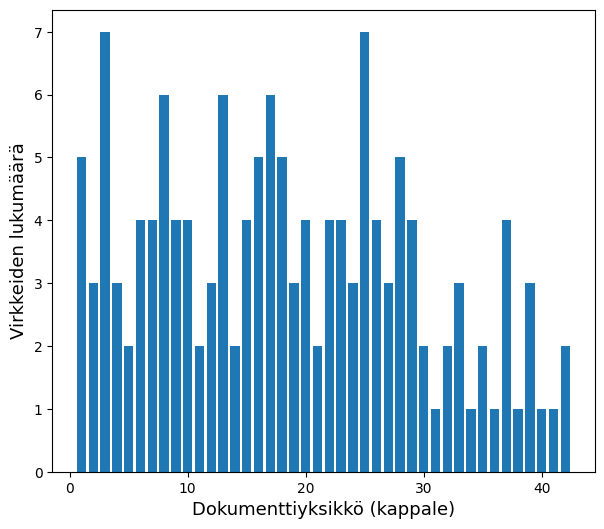

In [10]:
values = [len(splitter.split(kpl)) for kpl in kappaleet.values()]
plt.figure(figsize=(7, 6))

fig = plt.bar(np.arange(1, len(values) + 1), values)
plt.xlabel("Dokumenttiyksikkö (kappale)", size=13)
plt.ylabel("Virkkeiden lukumäärä", size=13)
plt.show()

### Luodaan korpus

In [11]:
from tmtoolkit.corpus import dtm
from tmtoolkit.corpus import Corpus, print_summary

Luodaan korpus käyttäen Tmtoolkit-kirjaston Corpus-luokkaa

In [12]:
crp = Corpus({f"dok_{i}": str(kpl) for i, kpl in enumerate(kappaleet.values()) if len(str(kpl)) > 0}, "fi")
print_summary(crp)

Corpus with 42 documents in Finnish
> dok_13 (50 tokens): Demoja luodaan myös yhä useille vanhoille laitealu...
> dok_0 (83 tokens): Demoskenen juuret ovat 1980-luvun edullisten mikro...
> dok_12 (115 tokens): Laitetehon huima parantuminen sekä 3D-grafiikkakii...
> dok_14 (82 tokens): Aiemmin demoskene jakautui käytetyn laitteiston mu...
> dok_10 (48 tokens): 1990-luvun puolivälin tienoilla PC-demot alkoivat ...
> dok_11 (59 tokens): PC-koneilla suurin mullistus nähtiin 1990-luvun lo...
> dok_1 (67 tokens): Demoskene alkoi syntyä niihin aikoihin , kun osa p...
> dok_16 (129 tokens): Mitään selkeitä kriteereitä parhaiden demojen vali...
> dok_15 (93 tokens): Demoskene on hyvin kilpailuhenkinen alakulttuuri ,...
> dok_17 (77 tokens): Vuosina 2003-2012 järjestettiin Scene.org Awards ,...
(and 32 more documents)
total number of tokens: 2721 / vocabulary size: 1613


In [13]:
from tmtoolkit.topicmod.tm_lda import evaluate_topic_models
from tmtoolkit.topicmod.evaluate import results_by_parameter

In [14]:
from tmtoolkit.corpus import lemmatize, to_lowercase, remove_punctuation, filter_clean_tokens, remove_common_tokens, remove_uncommon_tokens

Karsitaan aihemallinnusta varten korpuksesta ei-haluttu informaatio pois ja lemmataan korpus

In [15]:
# Jos ei ole asetettu remove_shorter_than=4, tulee englanninkielinen sana "the" mukaan aiheita karakterisoivaksi sanaksi,
# koska haetaan vain suomenkielen stop wordeja

filter_clean_tokens(crp, remove_numbers=True, remove_stopwords=True, remove_shorter_than=4)
remove_punctuation(crp)
to_lowercase(crp)
lemmatize(crp)
remove_common_tokens(crp, df_threshold=0.85)
remove_uncommon_tokens(crp, df_threshold=0.05)
print_summary(crp)

Corpus with 42 documents in Finnish
> dok_13 (3 tokens): luoda Commodore käyttö
> dok_0 (12 tokens): 1980luku Demoskene peli ohjelma peli alkaa peli nä...
> dok_12 (14 tokens): tapahtua puoli ohjelmoija käyttää aika muu nykyään...
> dok_14 (14 tokens): demoskene laitteisto erilainen laite demo laite de...
> dok_10 (9 tokens): 1990luku puoliväli alkaa Amiga demo PC vuosi kehit...
> dok_11 (12 tokens): nähdä 1990luku siirtyä aika aika suuri tapahtuma t...
> dok_1 (8 tokens): Demoskene alkaa syntyä aika alkaa varhainen olla r...
> dok_16 (16 tokens): demo demo tuotos suuri pyrkiä suuri yleisö kuulua ...
> dok_15 (10 tokens): Demoskene demo ryhmä kuulua yleisö usea erillinen ...
> dok_17 (11 tokens): järjestää pyrkiä olla tapa jakaa jakaa vuosi vuosi...
(and 32 more documents)
total number of tokens: 397 / vocabulary size: 72


Luodaan korpuksesta dokumentti-termi-matriisi

In [16]:
dtm_, doc_labels_, vocab_ = dtm(crp, return_doc_labels=True, return_vocab=True)

Riippuen tmtoolkit-kirjaston asennuksesta metriikoita voi olla enemmänkin

In [17]:
import tmtoolkit.topicmod.tm_lda
tmtoolkit.topicmod.tm_lda.AVAILABLE_METRICS

('loglikelihood', 'cao_juan_2009', 'arun_2010', 'coherence_mimno_2011')

In [18]:
# Aihemallin evaluointifunktio
def evaluate(X, ts, te):

    const_params = {
        'n_iter': 1000,
        'random_state': 42,  # tulokset ovat toistettavissa
        'eta': 0.1,          # joskus käytetään nimitystä "beta", muistelen lukeneeni, että tämän suositellaan olevan "pieni" arvo
    }

    # iteroidaan LDA-mallia eri määrillä aiheita
    var_params = [{'n_topics': k, 'alpha': 1/(10**k)}
                for k in range(ts, te)]
            
    return evaluate_topic_models(X, varying_parameters=var_params,
                                     constant_parameters=const_params,
                                     coherence_mimno_2011_top_n=5,
                                     coherence_mimno_2011_include_prob=True,
                                     return_models=True)

In [19]:
ts = 2                      # aiheita pyritään samaan vähintään 2
te = len(kappaleet)         # maksimi määrä aiheille on korpukseen niputettujen virkeryppäiden määrä
                            # tässä tiedetään, että yksi kappaleista on tyhjä, joka ei ole mukana, siksi ei + 1:tä
ts, te

(2, 42)

Määritetään dokumentti-termi-matriisista aiheet ja luetaan aihemallinnuksen tulokset

In [20]:
tulokset = evaluate(dtm_, ts, te)
eval_results_by_topics = results_by_parameter(tulokset, 'n_topics')

In [21]:
# kerätään koherenssitulokset
koherenssi = []
for i in range(len(eval_results_by_topics)):
    koherenssi.append(eval_results_by_topics[i][1]["coherence_mimno_2011"])

Koherennsin tulee olla mahdollisimman suuri

In [22]:
parhaan_mallin_indeksi = np.argmax(koherenssi)
paras_Mimno_LDA = eval_results_by_topics[parhaan_mallin_indeksi][1]["model"]

Alla olevassa taulukossa itse taulukon indeksi kertoo ko. indeksiä edustavan aiheeseen liittyvän dokumenttiyksikön indeksin

In [23]:
topic_nums = []

topic_results = paras_Mimno_LDA.transform(dtm_)
for topic_dist in topic_results:
    topic_num = topic_dist.argmax()
    topic_nums.append(topic_num)
print("Aiheet:", topic_nums)
print("Aiheiden määrä:", paras_Mimno_LDA.n_topics)

Aiheet: [8, 0, 8, 1, 1, 6, 14, 10, 3, 2, 16, 7, 4, 7, 9, 11, 5, 13, 13, 1, 9, 6, 0, 4, 10, 13, 6, 9, 0, 14, 12, 16, 4, 8, 13, 2, 4, 3, 15, 3, 8, 5]
Aiheiden määrä: 17


Piirretään graafi koherenssista suhteessa aiheiden määrään

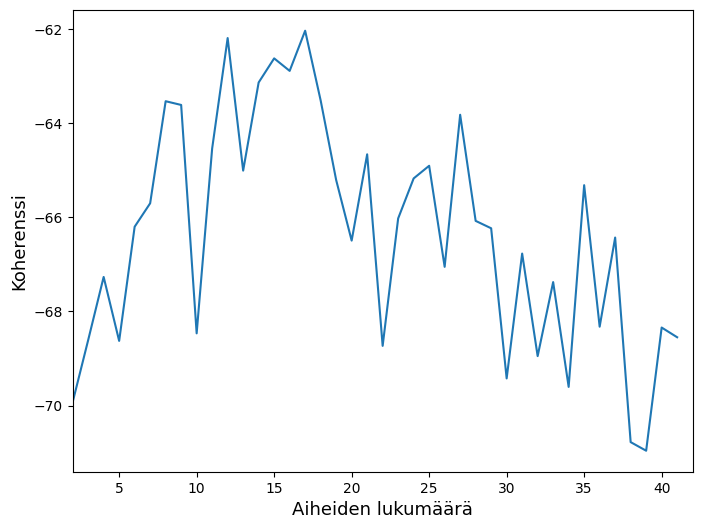

In [24]:
xs = np.arange(2,len(koherenssi)+2)

plt.figure(figsize=(8, 6))
fig = plt.plot(xs,koherenssi)
plt.xlim(2,len(koherenssi)+2)
plt.xlabel("Aiheiden lukumäärä", size=13)
plt.ylabel("Koherenssi", size=13)
plt.show()

In [25]:
from tmtoolkit.topicmod.model_stats import generate_topic_labels_from_top_words

In [26]:
from tmtoolkit.topicmod.model_io import print_ldamodel_topic_words, doc_lengths

Tulostetaan Tmtoolkit-kirjaston sisäisillä metodeilla aihesanat

In [27]:
vocab = np.array(vocab_)   # sanaston tulee olla NumPy array

doc_lengths_ = doc_lengths(dtm_)
topic_labels = generate_topic_labels_from_top_words(
    paras_Mimno_LDA.topic_word_,
    paras_Mimno_LDA.doc_topic_,
    doc_lengths_,
    np.array(vocab),
    lambda_=0.6
)

print_ldamodel_topic_words(paras_Mimno_LDA.topic_word_, vocab, top_n=11)

topic_1
> #1. ryhmä (0.153614)
> #2. jäsen (0.093373)
> #3. alkaa (0.063253)
> #4. suomalainen (0.063253)
> #5. Future (0.033133)
> #6. pelkästään (0.033133)
> #7. demoryhmi (0.033133)
> #8. demo (0.033133)
> #9. aika (0.033133)
> #10. sarka (0.033133)
> #11. syntyä (0.033133)
topic_2
> #1. aika (0.077114)
> #2. 1990luku (0.077114)
> #3. käyttää (0.077114)
> #4. laitteisto (0.052239)
> #5. ohjelmoija (0.052239)
> #6. demo (0.052239)
> #7. puoli (0.052239)
> #8. toinen (0.027363)
> #9. puoliväli (0.027363)
> #10. jäsen (0.027363)
> #11. järjestää (0.027363)
topic_3
> #1. vuosi (0.176724)
> #2. jakaa (0.133621)
> #3. järjestää (0.090517)
> #4. yleisö (0.047414)
> #5. tapahtuma (0.047414)
> #6. olla (0.047414)
> #7. demoskenen (0.047414)
> #8. demoryhmi (0.047414)
> #9. tapa (0.047414)
> #10. pyrkiä (0.047414)
> #11. Finnish (0.004310)
topic_4
> #1. demo (0.209544)
> #2. alkaa (0.085062)
> #3. nykyinen (0.064315)
> #4. yleisö (0.043568)
> #5. demoskenen (0.043568)
> #6. kehitys (0.043568)

In [28]:
topic_labels

array(['1_ryhmä_jäsen', '2_aika_käyttää', '3_vuosi_jakaa',
       '4_demo_nykyinen', '5_alkaa_demoskenen', '6_Future_PC',
       '7_käyttö_demoskene', '8_tapahtuma_henkilö', '9_Amiga_peli',
       '10_Suomi_PC', '11_ryhmä_Demoskene', '12_tapahtuma_tuotos',
       '13_valtaosa_suomalainen', '14_musiikki_ryhmä', '15_laite_saada',
       '16_kone_syntyä', '17_ihminen_pitää'], dtype='<U23')

Aihesanat graafisena sanapilvenä, tarvitsee myös "pip install wordcloud"

In [29]:
from tmtoolkit.topicmod.visualize import generate_wordclouds_for_topic_words

In [30]:
# luodaan aihesanapilvi 11 aihesanalla
topic_clouds = generate_wordclouds_for_topic_words(
    paras_Mimno_LDA.topic_word_, vocab,
    top_n=11, topic_labels=topic_labels,
    width=800, height=600,
    return_images = True)

# katsotaan jokaisen aiheen sanapilvi, huomataan, että kyseessä on Pythonin dict-tietorakenne,
# jossa avaimena on aiheen numero ja aihetta eniten karakterisoiva sana. Avaimelle arvona on Image saaduilla tiedoilla
topic_clouds

{'1_ryhmä_jäsen': <PIL.Image.Image image mode=RGBA size=800x600>,
 '2_aika_käyttää': <PIL.Image.Image image mode=RGBA size=800x600>,
 '3_vuosi_jakaa': <PIL.Image.Image image mode=RGBA size=800x600>,
 '4_demo_nykyinen': <PIL.Image.Image image mode=RGBA size=800x600>,
 '5_alkaa_demoskenen': <PIL.Image.Image image mode=RGBA size=800x600>,
 '6_Future_PC': <PIL.Image.Image image mode=RGBA size=800x600>,
 '7_käyttö_demoskene': <PIL.Image.Image image mode=RGBA size=800x600>,
 '8_tapahtuma_henkilö': <PIL.Image.Image image mode=RGBA size=800x600>,
 '9_Amiga_peli': <PIL.Image.Image image mode=RGBA size=800x600>,
 '10_Suomi_PC': <PIL.Image.Image image mode=RGBA size=800x600>,
 '11_ryhmä_Demoskene': <PIL.Image.Image image mode=RGBA size=800x600>,
 '12_tapahtuma_tuotos': <PIL.Image.Image image mode=RGBA size=800x600>,
 '13_valtaosa_suomalainen': <PIL.Image.Image image mode=RGBA size=800x600>,
 '14_musiikki_ryhmä': <PIL.Image.Image image mode=RGBA size=800x600>,
 '15_laite_saada': <PIL.Image.Image i

In [31]:

# poimitaan aihe
im = topic_clouds["9_Amiga_peli"]

Edellä saaduissa kuvissa on läpinäkyvyyttä, ts. niiden alpha ei ole kaikkialla 255.
Seuraavaksi konvertoidaan kuvat antialiasoiduiksi kuviksi ilman läpinäkyvyytä, ts. alpha = 255 kaikkialla.

In [32]:
from PIL import Image

In [33]:
# Luo uusi kuva, jossa on valkoinen tausta ja RGBA-tila
antialiased_image = Image.new("RGBA", im.size, (255, 255, 255, 255))
# Liimataan alkuperäinen kuva tähän uuteen antialiasoituun kuvaan
antialiased_image.paste(im, (0, 0), im)

# ainakin Windows 11:ssa seuraava koodirivi avaa järjestelmän kuvankatseluohjelman
antialiased_image.show()

Tulostetaan aiheet

In [34]:
# Tulostetaan aihekokonaisuudet
for t in range(paras_Mimno_LDA.n_topics):
    print(f"\n=== Aihe {t+1} ===")
    for i, k in enumerate(topic_nums):
        if k == t:
            print() # tyhjä rivi osoittamaan, mistä alkaa seuraava dokumenttiyksikkö
            virkkeet = splitter.split(korpus[i])
            for virke in virkkeet:
                print(virke)


=== Aihe 1 ===

Demoskene alkoi syntyä niihin aikoihin, kun osa piraattiryhmistä alkoi kilpailla kräkkäystaitojen ja levittämisnopeuden lisäksi myös introjen paremmuudella ja julkaista niitä myös erillään ohjelmakopioista.
Ensimmäisiä varhaisia tapauksia demoskeneryhmistä olivat alankomaalaiset 1001 Crew (alun perin 1001 & the Cracking Crew) ja The Judges.
Tuolloin olemassa olevat ryhmät kilpailivat tiiviisti ensimmäisinä luoduista ohjelmointisaavutuksista, joita mainostettiin kovaan ääneen joko itse tuotoksessa tai sitä levittäessä.

Demopartyt ovat yleensä viikonlopun yli kestäviä tapahtumia, joihin kuuluu olennaisesti pimeä tila, jossa on videotykki tuotosten esittämistä varten.
Tapahtumat ovat tavallisesti keskeytyksettömiä, ja useimmat kävijät myös yöpyvät paikan päällä.
Monet ottavat tapahtumiin mukaan myös omia tietokoneitaan tuotosten viimeistelyä tai ajanvietettä varten, minkä vuoksi päätilassa on sähköistettyä pöytätilaa ja yleensä myös lähiverkko.
Osa demopartyistä muistutt